# Extended Analysis using Word2Vec & Deep Learning
Fasttext di-disable dikarenakan tidak ada data train & test nya.

## Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
# import fasttext

import keras
from keras.layers import Input, Bidirectional, LSTM, Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, TextVectorization
from keras.models import Model, Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import svm, naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import MinMaxScaler

import seaborn as sn
import matplotlib.pyplot as plt

2022-08-19 10:31:39.171373: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load Data

### Convert Label to Integer

In [2]:
# data = pd.read_csv(path+"clean_blt_data_5000_labeled.csv")
# data['Label'] = data['Label'].astype('category').cat.codes
data = pd.read_csv("data/tweets_labelled_nltk.csv")

def merge_neutral(text):
    if text == "Netral":
        return "Positif"
    if text == "Positif":
        return "Positif"
    else:
        return "Negatif"

data['sentimen'] = data['sentimen'].apply(merge_neutral)
data

data['Label'] = data['sentimen'].astype('category').cat.codes
data['Comment'] = data['tweet'].astype('U')
data['Tweet'] = data['tweet'].astype('U')
data = data.drop('tweet', axis=1)

In [3]:
data.head(20)

sentimen  Label                                            Comment  \
0   Positif      1  menangani  kekerasan  seksual  disahkan  enam ...   
1   Positif      1  menangani  kekerasan  seksual  disahkan  enam ...   
2   Negatif      0     wakil  mpr  ri  mahasiswa  kawal  implementasi   
3   Negatif      0    fadel  muhammad  mahasiswa  kawal  implementasi   
4   Negatif      0                   tanggal  chatnya  april  dijerat   
5   Positif      1                              kelakuan  gini  ranah   
6   Negatif      0  membuka  sistem  peradilan  diharapkan  implem...   
7   Negatif      0  mochammad  abizar  yusro  terang  sinar  perli...   
8   Positif      1  pengesahan  undang undang  bentuk  hadiah  per...   
9   Positif      1  ri  penghargaan  elemen  perempuan  pengesahan...   
10  Positif      1  haru  lega  rasakan  beleid  disahkan  pengesa...   
11  Positif      1  sah  tunggu  perbaikan  kuhp  melegitimasi  pa...   
12  Positif      1  perwakilan  pejuang  berterima  kasih  mereali...   
13  Negatif      0  implementasi  menyelesaikan  kasus kasus  keke...   
14  Positif      1               dinilai  berperan  pengesahan  sobat   
15  Positif      1  memiliki  sensitivitas  kepedulian  perempuan ...   
16  Positif      1  berkoordinasi  pemerintah  presiden  joko  wid...   
17  Positif      1  menko  pmk  salah  tokoh  memperjuangkan  disa...   
18  Positif      1  perwakilan  pejuang  berterima  kasih  mereali...   
19  Positif      1  implementasi  menghadapi  menyelesaikan  kasus...   

                                                Tweet  
0   menangani  kekerasan  seksual  disahkan  enam ...  
1   menangani  kekerasan  seksual  disahkan  enam ...  
2      wakil  mpr  ri  mahasiswa  kawal  implementasi  
3     fadel  muhammad  mahasiswa  kawal  implementasi  
4                    tanggal  chatnya  april  dijerat  
5                               kelakuan  gini  ranah  
6   membuka  sistem  peradilan  diharapkan  implem...  
7   mochammad  abizar  yusro  terang  sinar  perli...  
8   pengesahan  undang undang  bentuk  hadiah  per...  
9   ri  penghargaan  elemen  perempuan  pengesahan...  
10  haru  lega  rasakan  beleid  disahkan  pengesa...  
11  sah  tunggu  perbaikan  kuhp  melegitimasi  pa...  
12  perwakilan  pejuang  berterima  kasih  mereali...  
13  implementasi  menyelesaikan  kasus kasus  keke...  
14               dinilai  berperan  pengesahan  sobat  
15  memiliki  sensitivitas  kepedulian  perempuan ...  
16  berkoordinasi  pemerintah  presiden  joko  wid...  
17  menko  pmk  salah  tokoh  memperjuangkan  disa...  
18  perwakilan  pejuang  berterima  kasih  mereali...  
19  implementasi  menghadapi  menyelesaikan  kasus...

### Split Data to Train and Test

In [4]:
X = data['Tweet']
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1, stratify=y)

### Convert Word to Integer (Index) and Label to One Hot Encoding

In [5]:
max_seq_len = sum([len(x) for x in data['Tweet'].values]) / len([len(x) for x in data['Tweet'].values])
print(max_seq_len)
max_seq_len = np.round(max_seq_len).astype(int)
print("maximun sequence length : ", max_seq_len)
max_db_words = 100000

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=max_db_words, lower=True, char_level=False)
tokenizer.fit_on_texts(list(data['Tweet'].values))  #leaky
word_seq_train = tokenizer.texts_to_sequences(list(X_train.values))
word_seq_test = tokenizer.texts_to_sequences(list(X_test.values))
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

74.12634339815763
maximun sequence length :  74
tokenizing input data...
dictionary size:  11157


In [6]:
y_seq_train = to_categorical(y_train, num_classes = 2)
y_seq_test = to_categorical(y_test, num_classes = 2)

### Word Representation

#### TF-IDF

In [7]:
tfidf = TfidfVectorizer()
tfidf.fit(data['Tweet'].astype('U').tolist())
tfidf_train = tfidf.transform(X_train.values)
tfidf_test = tfidf.transform(X_test.values)

In [8]:
tfidf_train_df = pd.DataFrame(tfidf_train.todense(), columns=tfidf.get_feature_names_out())
tfidf_train_df

aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaaa  \
0       0.0    0.0     0.0      0.0           0.0                     0.0   
1       0.0    0.0     0.0      0.0           0.0                     0.0   
2       0.0    0.0     0.0      0.0           0.0                     0.0   
3       0.0    0.0     0.0      0.0           0.0                     0.0   
4       0.0    0.0     0.0      0.0           0.0                     0.0   
...     ...    ...     ...      ...           ...                     ...   
14063   0.0    0.0     0.0      0.0           0.0                     0.0   
14064   0.0    0.0     0.0      0.0           0.0                     0.0   
14065   0.0    0.0     0.0      0.0           0.0                     0.0   
14066   0.0    0.0     0.0      0.0           0.0                     0.0   
14067   0.0    0.0     0.0      0.0           0.0                     0.0   

       aaaaaaaarghhh  aaaaamiiiiin  aaamin  aamiiiin  ...  zidan  zina  zinah  \
0                0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1                0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
2                0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
3                0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
4                0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
...              ...           ...     ...       ...  ...    ...   ...    ...   
14063            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
14064            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
14065            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
14066            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
14067            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   

       zinahal  zinalah  zinaseks  zona  zoom  zuhro  zuzur  
0          0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1          0.0      0.0       0.0   0.0   0.0    0.0    0.0  
2          0.0      0.0       0.0   0.0   0.0    0.0    0.0  
3          0.0      0.0       0.0   0.0   0.0    0.0    0.0  
4          0.0      0.0       0.0   0.0   0.0    0.0    0.0  
...        ...      ...       ...   ...   ...    ...    ...  
14063      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
14064      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
14065      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
14066      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
14067      0.0      0.0       0.0   0.0   0.0    0.0    0.0  

[14068 rows x 11157 columns]

In [9]:
tfidf_test_df = pd.DataFrame(tfidf_test.todense(), columns=tfidf.get_feature_names_out())
tfidf_test_df

aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaaa  \
0      0.0    0.0     0.0      0.0           0.0                     0.0   
1      0.0    0.0     0.0      0.0           0.0                     0.0   
2      0.0    0.0     0.0      0.0           0.0                     0.0   
3      0.0    0.0     0.0      0.0           0.0                     0.0   
4      0.0    0.0     0.0      0.0           0.0                     0.0   
...    ...    ...     ...      ...           ...                     ...   
1559   0.0    0.0     0.0      0.0           0.0                     0.0   
1560   0.0    0.0     0.0      0.0           0.0                     0.0   
1561   0.0    0.0     0.0      0.0           0.0                     0.0   
1562   0.0    0.0     0.0      0.0           0.0                     0.0   
1563   0.0    0.0     0.0      0.0           0.0                     0.0   

      aaaaaaaarghhh  aaaaamiiiiin  aaamin  aamiiiin  ...  zidan  zina  zinah  \
0               0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1               0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
2               0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
3               0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
4               0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
...             ...           ...     ...       ...  ...    ...   ...    ...   
1559            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1560            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1561            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1562            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   
1563            0.0           0.0     0.0       0.0  ...    0.0   0.0    0.0   

      zinahal  zinalah  zinaseks  zona  zoom  zuhro  zuzur  
0         0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1         0.0      0.0       0.0   0.0   0.0    0.0    0.0  
2         0.0      0.0       0.0   0.0   0.0    0.0    0.0  
3         0.0      0.0       0.0   0.0   0.0    0.0    0.0  
4         0.0      0.0       0.0   0.0   0.0    0.0    0.0  
...       ...      ...       ...   ...   ...    ...    ...  
1559      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1560      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1561      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1562      0.0      0.0       0.0   0.0   0.0    0.0    0.0  
1563      0.0      0.0       0.0   0.0   0.0    0.0    0.0  

[1564 rows x 11157 columns]

#### Bag of Words

In [10]:
countword = CountVectorizer()
countword.fit(data['Tweet'].astype('U').tolist())
countword_train = countword.transform(X_train.values)
countword_test = countword.transform(X_test.values)

In [11]:
count_vect_train_df = pd.DataFrame(countword_train.todense(), columns=countword.get_feature_names_out())
count_vect_train_df

aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaaa  \
0         0      0       0        0             0                       0   
1         0      0       0        0             0                       0   
2         0      0       0        0             0                       0   
3         0      0       0        0             0                       0   
4         0      0       0        0             0                       0   
...     ...    ...     ...      ...           ...                     ...   
14063     0      0       0        0             0                       0   
14064     0      0       0        0             0                       0   
14065     0      0       0        0             0                       0   
14066     0      0       0        0             0                       0   
14067     0      0       0        0             0                       0   

       aaaaaaaarghhh  aaaaamiiiiin  aaamin  aamiiiin  ...  zidan  zina  zinah  \
0                  0             0       0         0  ...      0     0      0   
1                  0             0       0         0  ...      0     0      0   
2                  0             0       0         0  ...      0     0      0   
3                  0             0       0         0  ...      0     0      0   
4                  0             0       0         0  ...      0     0      0   
...              ...           ...     ...       ...  ...    ...   ...    ...   
14063              0             0       0         0  ...      0     0      0   
14064              0             0       0         0  ...      0     0      0   
14065              0             0       0         0  ...      0     0      0   
14066              0             0       0         0  ...      0     0      0   
14067              0             0       0         0  ...      0     0      0   

       zinahal  zinalah  zinaseks  zona  zoom  zuhro  zuzur  
0            0        0         0     0     0      0      0  
1            0        0         0     0     0      0      0  
2            0        0         0     0     0      0      0  
3            0        0         0     0     0      0      0  
4            0        0         0     0     0      0      0  
...        ...      ...       ...   ...   ...    ...    ...  
14063        0        0         0     0     0      0      0  
14064        0        0         0     0     0      0      0  
14065        0        0         0     0     0      0      0  
14066        0        0         0     0     0      0      0  
14067        0        0         0     0     0      0      0  

[14068 rows x 11157 columns]

In [12]:
count_vect_test_df = pd.DataFrame(countword_test.todense(), columns=countword.get_feature_names_out())
count_vect_test_df

aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaaaaa  aaaaaaaaaaaaaaaaaaaaaa  \
0        0      0       0        0             0                       0   
1        0      0       0        0             0                       0   
2        0      0       0        0             0                       0   
3        0      0       0        0             0                       0   
4        0      0       0        0             0                       0   
...    ...    ...     ...      ...           ...                     ...   
1559     0      0       0        0             0                       0   
1560     0      0       0        0             0                       0   
1561     0      0       0        0             0                       0   
1562     0      0       0        0             0                       0   
1563     0      0       0        0             0                       0   

      aaaaaaaarghhh  aaaaamiiiiin  aaamin  aamiiiin  ...  zidan  zina  zinah  \
0                 0             0       0         0  ...      0     0      0   
1                 0             0       0         0  ...      0     0      0   
2                 0             0       0         0  ...      0     0      0   
3                 0             0       0         0  ...      0     0      0   
4                 0             0       0         0  ...      0     0      0   
...             ...           ...     ...       ...  ...    ...   ...    ...   
1559              0             0       0         0  ...      0     0      0   
1560              0             0       0         0  ...      0     0      0   
1561              0             0       0         0  ...      0     0      0   
1562              0             0       0         0  ...      0     0      0   
1563              0             0       0         0  ...      0     0      0   

      zinahal  zinalah  zinaseks  zona  zoom  zuhro  zuzur  
0           0        0         0     0     0      0      0  
1           0        0         0     0     0      0      0  
2           0        0         0     0     0      0      0  
3           0        0         0     0     0      0      0  
4           0        0         0     0     0      0      0  
...       ...      ...       ...   ...   ...    ...    ...  
1559        0        0         0     0     0      0      0  
1560        0        0         0     0     0      0      0  
1561        0        0         0     0     0      0      0  
1562        0        0         0     0     0      0      0  
1563        0        0         0     0     0      0      0  

[1564 rows x 11157 columns]

#### Word2Vec

In [13]:
list_of_sentences = []
for x in list(data['Tweet'].values):
  temp = x.split()
  list_of_sentences.append(temp)

word_model = Word2Vec(list_of_sentences, vector_size=106, min_count=1, window=5, epochs=100)
pretrained_weights = word_model.wv.vectors

words_not_found = []
embed_dim = 106
nb_words = len(word_index) + 1
embedding_matrix_2 = np.zeros((nb_words, embed_dim))

for i, word in word_index.items():
    try:
        embedding_matrix_2[word, :] = word_model.wv[i]
    except KeyError:
        pass

In [14]:
for i, word in word_index.items():
    try:
        print(i)
        print(word_model.wv[i])
        print("="*30)
    except KeyError:
        pass

disahkan
[ 0.8735333   1.4679219   0.48762748  0.09927639  0.5198297   0.04534492
  0.270053    1.8917394   1.3876      0.99306905  0.12281165  1.316289
  0.24620162 -0.31607878  1.2161674  -0.5725916   1.2845153   0.544261
  0.22215042 -0.6058074  -0.5667619   0.72167766  1.2103043  -0.93284625
  0.37075457 -0.53825164  1.7865267   0.13215744 -0.87282497  1.2005221
 -0.07449286 -1.9177743  -0.27002853 -0.3368091   0.5836056   0.8559916
  0.715352   -0.10337698 -1.989097    1.0962147   0.21751566  0.22518049
 -2.1942215   0.27199537 -0.47748     0.6800055  -1.5669823   1.226305
  1.352225   -0.04475161 -1.1935279   0.97635025  0.33298466  0.0597677
  0.52616763 -0.1395511  -0.6119579  -0.29818547 -0.75045276 -1.5567776
 -0.9751894   1.1382828  -2.322988   -0.48167047 -1.1728946   1.560503
  0.74237293  0.3467867   1.0526668   0.00673444  1.5799112   0.83606017
 -1.3565285  -1.2106925  -0.9783756  -1.5557781   0.38526446  0.09399598
 -0.15817805 -0.8187341   0.86925375 -0.05302118 -0.28

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[-0.22569583 -0.212173   -0.22769004  0.20811221 -0.06499133 -0.05179707
 -0.16594818 -0.01065668  0.16937819 -0.05767302  0.30342272 -0.01292008
 -0.17414093 -0.00800245 -0.3252896   0.17942251  0.10113842 -0.09710248
 -0.02621201 -0.14822102  0.29842356 -0.01803089  0.24844924  0.01499933
  0.0304348  -0.23585773 -0.28658363 -0.08510026  0.09698808 -0.08293153
  0.01185143  0.08689292 -0.05982696 -0.09866426  0.36691386  0.12863308
  0.05807047 -0.29743287  0.2483475   0.04144388 -0.2622737   0.03847696
 -0.10215561 -0.20986575  0.3642466   0.08463404 -0.16966866  0.07395548
 -0.11434381 -0.29690728  0.10593822  0.204649   -0.04107233 -0.02215947
  0.3649895   0.04381162  0.02170396 -0.13743229 -0.13172697  0.2685562
 -0.08389951 -0.3687844  -0.09641413 -0.15441288  0.08391834 -0.17595784
 -0.2004881   0.00998779 -0.20015934  0.0313158   0.15780456 -0.21500067
  0.24840663  0.12851933  0.12024925 -0.07952323 -0.12556641  0.13945164
 -0.10843909 -0.0721737  -0.13524967 -0.08117594  0.

#### Fasttext

In [15]:
# ### OPEN THIS CODE IF YOU WANT TO TRAIN FASTTEXT MODEL ###

# with open(path + 'Word_Embedding_Fasttext/data_train.txt', 'a') as f:
#     for x in range(0, len(X_train)):
#         f.write("__label__"+ str(y_train.values[x]) + " " +X_train.values[x] + "\n")

# with open(path + 'Word_Embedding_Fasttext/data_test.txt', 'a') as f:
#     for x in range(0, len(X_test)):
#         f.write("__label__"+ str(y_test.values[x]) + " " +X_test.values[x] + "\n")

# model_fasttext = fasttext.train_supervised(input=path + 'Word_Embedding_Fasttext/data_train.txt', autotuneValidationFile=path + 'Word_Embedding_Fasttext/data_test.txt')
# # model_fasttext.save_model(path + 'Word_Embedding_Fasttext/model_ft.bin')

# ### OPEN THIS CODE IF YOU WANT TO LOAD FASTTEXT MODEL ###

# # model_fasttext = fasttext.load_model(path + 'Word_Embedding_Fasttext/model.bin')

# ########################################################################################################

# np.random.seed(0)
# print('preparing embedding matrix...')

# words_not_found = []
# embed_dim = len(model_fasttext['tes'])
# nb_words = max(len(model_fasttext.words), len(word_index)) +1
# embedding_matrix = np.zeros((nb_words, embed_dim))

# for i, word in enumerate(model_fasttext.words):
#     if i >= nb_words:
#         continue
#     embedding_vector = model_fasttext[word]
#     if (embedding_vector is not None) and len(embedding_vector) > 0:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
#     else:
#         words_not_found.append(word)
# print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [16]:
# for i, word in enumerate(model_fasttext.words):
#     if i >= nb_words:
#         continue
#     embedding_vector = model_fasttext[word]
#     if (embedding_vector is not None) and len(embedding_vector) > 0:
#         # words not found in embedding index will be all-zeros.
#         print(word)
#         print(embedding_vector)
#         print("="*30)
#     else:
#         words_not_found.append(word)

## Evaluation Function

In [17]:
def plot_matrix(y_test, y_pred):
  cnf_matrix = confusion_matrix(y_test, y_pred)
  index = ["negative", "positive"]
  columns = ["negative", "positive"]
  df_cm = pd.DataFrame(cnf_matrix,columns,index)

  sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt=".0f", annot_kws={"size": 10}) # font size
  plt.xlabel("Predicted label", fontsize = 10)
  plt.ylabel("True label", fontsize = 10)

  plt.show()

In [18]:
def false_cases(sentences, y_test, y_pred):
  df = pd.DataFrame(list(zip(sentences, y_test, y_pred)), columns=["sentence", "label", "prediction"])
  df = df[df['label'] != df['prediction']]
  return df


In [19]:
target_names = ["negative", "positive"]

## Deep Learning

### ANN

#### Fastext

In [20]:
# ann_fasttext = Sequential()
# ann_fasttext.add(Embedding(nb_words, 33, input_length=max_seq_len, weights=[embedding_matrix])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
# ann_fasttext.add(Dense(10, activation='relu'))
# ann_fasttext.add(Dropout(0.2))
# ann_fasttext.add(Dense(5, activation='relu'))
# ann_fasttext.add(Flatten())
# ann_fasttext.add(Dense(2, activation='softmax'))
# ann_fasttext.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# ann_fasttext.summary()

# ann_fasttext.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

In [21]:
# y_pred = ann_fasttext.predict(word_seq_test, verbose=0)
# y_pred = np.argmax(y_pred, axis=1)

In [22]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [23]:
# plot_matrix(y_test, y_pred)

In [24]:
# pred_result = false_cases(X_test, y_test, y_pred)
# pred_result

#### Word2Vec

In [25]:
ann_word2vec = Sequential()
ann_word2vec.add(Embedding(nb_words, 106, input_length=max_seq_len, weights=[embedding_matrix_2])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
ann_word2vec.add(Dense(10, activation='relu'))
ann_word2vec.add(Dropout(0.2))
ann_word2vec.add(Dense(5, activation='relu'))
ann_word2vec.add(Flatten())
ann_word2vec.add(Dense(2, activation='softmax'))
ann_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_word2vec.summary()

ann_word2vec.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

2022-08-19 10:32:44.419627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 10:32:44.463735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 10:32:44.463907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 10:32:44.464526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 106)           1182748   
                                                                 
 dense (Dense)               (None, 74, 10)            1070      
                                                                 
 dropout (Dropout)           (None, 74, 10)            0         
                                                                 
 dense_1 (Dense)             (None, 74, 5)             55        
                                                                 
 flatten (Flatten)           (None, 370)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 742       
                                                                 
Total params: 1,184,615
Trainable params: 1,184,615
Non-

2022-08-19 10:33:00.307444: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


440/440 [==============================] - 9s 7ms/step - loss: 0.4391 - accuracy: 0.8011 - val_loss: 0.3416 - val_accuracy: 0.8510
Epoch 2/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8664 - val_loss: 0.2671 - val_accuracy: 0.8862
Epoch 3/10
440/440 [==============================] - 1s 2ms/step - loss: 0.2367 - accuracy: 0.9047 - val_loss: 0.2397 - val_accuracy: 0.8983
Epoch 4/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1829 - accuracy: 0.9274 - val_loss: 0.2178 - val_accuracy: 0.9175
Epoch 5/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1400 - accuracy: 0.9468 - val_loss: 0.2167 - val_accuracy: 0.9162
Epoch 6/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1150 - accuracy: 0.9575 - val_loss: 0.2204 - val_accuracy: 0.9226
Epoch 7/10
440/440 [==============================] - 1s 2ms/step - loss: 0.0961 - accuracy: 0.9655 - val_loss: 0.2298 - val_accuracy: 0.9124
Epoch 8/10
440/44

In [26]:
y_pred = ann_word2vec.predict(word_seq_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [27]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.78      0.82       328
    positive       0.94      0.96      0.95      1236

    accuracy                           0.93      1564
   macro avg       0.90      0.87      0.88      1564
weighted avg       0.92      0.93      0.92      1564



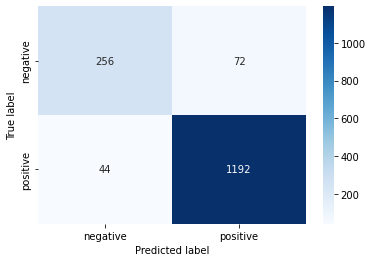

In [28]:
plot_matrix(y_test, y_pred)

In [29]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

sentence  label  prediction
23    capek  capek  disahkan  nyampe  pelaksanaan  p...      0           1
30    sepi  kayaknya  sidang  paripurna  yak  disahk...      0           1
99    harta  rampasan  perang  peroleh  allah  mahap...      1           0
134   anggota  parlemen  mensyahkan  didalamnya  did...      1           0
149                      diharapkan  penolak  wkwkwkwkw      0           1
...                                                 ...    ...         ...
1519                 disahkan  aturan  turunan  disusun      1           0
1522  mengakomodasi  pemidanaan  pelaku  penyimpanga...      0           1
1527  fokus  kasih  perlindungan  korban  ks  hak  k...      0           1
1538  kebodohan  predator  seksual  gamau  bikin  em...      0           1
1541                                 tertawa  selingkuh      1           0

[116 rows x 3 columns]

### CNN

#### Fastext

In [30]:
# cnn_fasttext = Sequential()
# cnn_fasttext.add(Embedding(nb_words, 33, input_length=max_seq_len, weights=[embedding_matrix])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
# cnn_fasttext.add(Conv1D(32, kernel_size=5, activation='relu'))
# cnn_fasttext.add(MaxPooling1D(pool_size=2))
# cnn_fasttext.add(Conv1D(64, kernel_size=5, activation='relu'))
# cnn_fasttext.add(MaxPooling1D(pool_size=2))
# cnn_fasttext.add(Flatten())
# cnn_fasttext.add(Dense(10, activation='relu'))
# cnn_fasttext.add(Dropout(0.2))
# cnn_fasttext.add(Dense(2, activation='softmax'))
# cnn_fasttext.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# cnn_fasttext.summary()

# cnn_fasttext.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

In [31]:
# y_pred = cnn_fasttext.predict(word_seq_test, verbose=0)
# y_pred = np.argmax(y_pred, axis=1)

In [32]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [33]:
# plot_matrix(y_test, y_pred)

In [34]:
# pred_result = false_cases(X_test, y_test, y_pred)
# pred_result

#### Word2Vec

In [35]:
cnn_word2vec = Sequential()
cnn_word2vec.add(Embedding(nb_words, 106, input_length=max_seq_len, weights=[embedding_matrix_2])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
cnn_word2vec.add(Conv1D(32, kernel_size=5, activation='relu'))
cnn_word2vec.add(MaxPooling1D(pool_size=2))
cnn_word2vec.add(Conv1D(64, kernel_size=5, activation='relu'))
cnn_word2vec.add(MaxPooling1D(pool_size=2))
cnn_word2vec.add(Flatten())
cnn_word2vec.add(Dense(10, activation='relu'))
cnn_word2vec.add(Dropout(0.2))
cnn_word2vec.add(Dense(2, activation='softmax'))
cnn_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_word2vec.summary()

cnn_word2vec.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 74, 106)           1182748   
                                                                 
 conv1d (Conv1D)             (None, 70, 32)            16992     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 35, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 31, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 960)              

2022-08-19 10:33:17.706617: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


440/440 [==============================] - 19s 20ms/step - loss: 0.3800 - accuracy: 0.8340 - val_loss: 0.3161 - val_accuracy: 0.8689
Epoch 2/10
440/440 [==============================] - 1s 2ms/step - loss: 0.2612 - accuracy: 0.8917 - val_loss: 0.2683 - val_accuracy: 0.8919
Epoch 3/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1966 - accuracy: 0.9243 - val_loss: 0.2563 - val_accuracy: 0.8983
Epoch 4/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1409 - accuracy: 0.9485 - val_loss: 0.2941 - val_accuracy: 0.8964
Epoch 5/10
440/440 [==============================] - 1s 2ms/step - loss: 0.1064 - accuracy: 0.9647 - val_loss: 0.3398 - val_accuracy: 0.8951
Epoch 6/10
440/440 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9713 - val_loss: 0.3400 - val_accuracy: 0.9028
Epoch 7/10
440/440 [==============================] - 1s 2ms/step - loss: 0.0749 - accuracy: 0.9738 - val_loss: 0.4144 - val_accuracy: 0.9047
Epoch 8/10
440/

In [36]:
y_pred = cnn_word2vec.predict(word_seq_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [37]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.81      0.73      0.77       328
    positive       0.93      0.95      0.94      1236

    accuracy                           0.91      1564
   macro avg       0.87      0.84      0.85      1564
weighted avg       0.90      0.91      0.90      1564



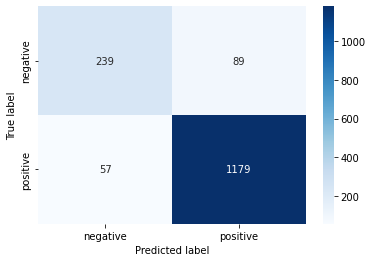

In [38]:
plot_matrix(y_test, y_pred)

In [39]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

sentence  label  prediction
20    kopri  pb  pmii  mengawal  implementasi  via  ...      1           0
23    capek  capek  disahkan  nyampe  pelaksanaan  p...      0           1
28    kebut  aturan  turunan  dirasakan  implementas...      1           0
59                              poinpoin  pkb  elgenaro      1           0
96                                  bnyak  cowok  takut      0           1
...                                                 ...    ...         ...
1500  seandainya  pdp  disahkan  pengguna  data  pri...      1           0
1510                    sekian  payung  hukum  pahlawan      1           0
1522  mengakomodasi  pemidanaan  pelaku  penyimpanga...      0           1
1527  fokus  kasih  perlindungan  korban  ks  hak  k...      0           1
1534                                        kp  ite  sg      1           0

[146 rows x 3 columns]

### LSTM

#### Fastext

In [40]:
# lstm_fasttext = Sequential()
# lstm_fasttext.add(Embedding(nb_words, 33, input_length=max_seq_len, weights=[embedding_matrix])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
# lstm_fasttext.add(LSTM(10, return_sequences=True))
# lstm_fasttext.add(LSTM(5))
# lstm_fasttext.add(Dropout(0.2))
# lstm_fasttext.add(Dense(5))
# lstm_fasttext.add(Dense(2, activation='softmax'))
# lstm_fasttext.summary()
# lstm_fasttext.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# lstm_fasttext.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

In [41]:
# y_pred = lstm_fasttext.predict(word_seq_test, verbose=0)
# y_pred = np.argmax(y_pred, axis=1)

In [42]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [43]:
# plot_matrix(y_test, y_pred)

In [44]:
# pred_result = false_cases(X_test, y_test, y_pred)
# pred_result

#### Word2Vec

In [45]:
lstm_word2vec = Sequential()
lstm_word2vec.add(Embedding(nb_words, 106, input_length=max_seq_len, weights=[embedding_matrix_2])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
lstm_word2vec.add(LSTM(10, return_sequences=True))
lstm_word2vec.add(LSTM(5))
lstm_word2vec.add(Dropout(0.2))
lstm_word2vec.add(Dense(5))
lstm_word2vec.add(Dense(2, activation='softmax'))
lstm_word2vec.summary()
lstm_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_word2vec.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 74, 106)           1182748   
                                                                 
 lstm (LSTM)                 (None, 74, 10)            4680      
                                                                 
 lstm_1 (LSTM)               (None, 5)                 320       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense_5 (Dense)             (None, 5)                 30        
                                                                 
 dense_6 (Dense)             (None, 2)                 12        
                                                                 
Total params: 1,187,790
Trainable params: 1,187,790
No

In [46]:
y_pred = lstm_word2vec.predict(word_seq_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [47]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       328
    positive       0.96      0.95      0.95      1236

    accuracy                           0.93      1564
   macro avg       0.89      0.89      0.89      1564
weighted avg       0.93      0.93      0.93      1564



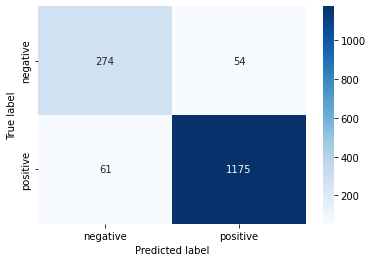

In [48]:
plot_matrix(y_test, y_pred)

In [49]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

sentence  label  prediction
1                                           rispek  sah      1           0
4     hasil  tes  kecepatan  internet  telekomunikas...      1           0
8                    daftar  kekerasan  seksual  diatur      0           1
20    kopri  pb  pmii  mengawal  implementasi  via  ...      1           0
23    capek  capek  disahkan  nyampe  pelaksanaan  p...      0           1
...                                                 ...    ...         ...
1514  wni  mesti  berterimakasih  beliau  mengesahka...      1           0
1522  mengakomodasi  pemidanaan  pelaku  penyimpanga...      0           1
1527  fokus  kasih  perlindungan  korban  ks  hak  k...      0           1
1534                                        kp  ite  sg      1           0
1543  intinya  video  dibikin  consent  disebarin  s...      0           1

[115 rows x 3 columns]

### BLSTM

#### Fastext

In [50]:
# blstm_fasttext = Sequential()
# blstm_fasttext.add(Embedding(nb_words, 33, input_length=max_seq_len, weights=[embedding_matrix])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
# blstm_fasttext.add(Bidirectional(LSTM(10, return_sequences=True)))
# blstm_fasttext.add(Bidirectional(LSTM(5)))
# blstm_fasttext.add(Dropout(0.2))
# blstm_fasttext.add(Dense(5))
# blstm_fasttext.add(Dense(2, activation='softmax'))
# blstm_fasttext.summary()
# blstm_fasttext.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# blstm_fasttext.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

In [51]:
# y_pred = blstm_fasttext.predict(word_seq_test, verbose=0)
# y_pred = np.argmax(y_pred, axis=1)

In [52]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [53]:
# plot_matrix(y_test, y_pred)

In [54]:
# pred_result = false_cases(X_test, y_test, y_pred)
# pred_result

#### Word2Vec

In [55]:
blstm_word2vec = Sequential()
blstm_word2vec.add(Embedding(nb_words, 106, input_length=max_seq_len, weights=[embedding_matrix_2])) #embedding_matrix_2 = word2vec ; embedding_matrix = fasttext
blstm_word2vec.add(Bidirectional(LSTM(10, return_sequences=True)))
blstm_word2vec.add(Bidirectional(LSTM(5)))
blstm_word2vec.add(Dropout(0.2))
blstm_word2vec.add(Dense(5))
blstm_word2vec.add(Dense(2, activation='softmax'))
blstm_word2vec.summary()
blstm_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

blstm_word2vec.fit(word_seq_train, y_seq_train, epochs=10, validation_data=(word_seq_test, y_seq_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 74, 106)           1182748   
                                                                 
 bidirectional (Bidirectiona  (None, 74, 20)           9360      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10)               1040      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
 dense_8 (Dense)             (None, 2)                

In [56]:
y_pred = blstm_word2vec.predict(word_seq_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)

In [57]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.87      0.82      0.84       328
    positive       0.95      0.97      0.96      1236

    accuracy                           0.94      1564
   macro avg       0.91      0.89      0.90      1564
weighted avg       0.94      0.94      0.94      1564



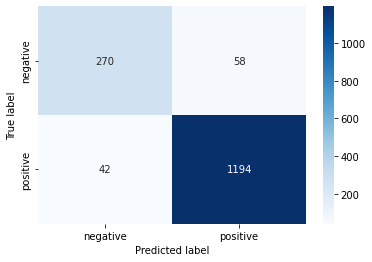

In [58]:
plot_matrix(y_test, y_pred)

In [59]:
pred_result = false_cases(X_test, y_test, y_pred)
pred_result

sentence  label  prediction
4     hasil  tes  kecepatan  internet  telekomunikas...      1           0
8                    daftar  kekerasan  seksual  diatur      0           1
30    sepi  kayaknya  sidang  paripurna  yak  disahk...      0           1
138   kawal  penegakkan  usut  pelaku  tuntas  bangu...      0           1
149                      diharapkan  penolak  wkwkwkwkw      0           1
...                                                 ...    ...         ...
1493  dahsyat  salut  perjuangannya  disahkan  cak  ...      0           1
1494  keren  banget  speakers  nyaa  topiknya  cocok...      1           0
1514  wni  mesti  berterimakasih  beliau  mengesahka...      1           0
1522  mengakomodasi  pemidanaan  pelaku  penyimpanga...      0           1
1527  fokus  kasih  perlindungan  korban  ks  hak  k...      0           1

[100 rows x 3 columns]

## Shallow Learning

### Feature Processing from embedding

#### Word2Vec

In [60]:
X_word2vec = []
for x in X:
  temp = []
  for y in x.split():
    temp.append(np.mean(word_model.wv[y]))
  if(len(x.split()) > max_seq_len):
    temp = temp[0:max_seq_len]
  else:
    temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
  X_word2vec.append(temp)

scaler_word2vec = MinMaxScaler()
scaler_word2vec.fit(X_word2vec)

MinMaxScaler()

In [61]:
X_train_word2vec = []
for x in X_train:
  temp = []
  for y in x.split():
    temp.append(np.mean(word_model.wv[y]))
  if(len(x.split()) > max_seq_len):
    temp = temp[0:max_seq_len]
  else:
    temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
  X_train_word2vec.append(temp)

X_train_word2vec_scaled = scaler_word2vec.transform(X_train_word2vec)

In [62]:
X_test_word2vec = []
for x in X_test:
  temp = []
  for y in x.split():
    temp.append(np.mean(word_model.wv[y]))
  if(len(x.split()) > max_seq_len):
    temp = temp[0:max_seq_len]
  else:
    temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
  X_test_word2vec.append(temp)

X_test_word2vec_scaled = scaler_word2vec.transform(X_test_word2vec)

#### Fasttext

In [63]:
# X_fasttext = []
# for x in X:
#   temp = []
#   for y in x.split():
#     temp.append(np.mean(model_fasttext[y]))
#   if(len(x.split()) > max_seq_len):
#     temp = temp[0:max_seq_len]
#   else:
#     temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
#   X_fasttext.append(temp)

# scaler_fasttext = MinMaxScaler()
# scaler_fasttext.fit(X_fasttext)

In [64]:
# X_train_fasttext = []
# for x in X_train:
#   temp = []
#   for y in x.split():
#     temp.append(np.mean(model_fasttext[y]))
#   if(len(x.split()) > max_seq_len):
#     temp = temp[0:max_seq_len]
#   else:
#     temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
#   X_train_fasttext.append(temp)

# X_train_fasttext_scaled = scaler_fasttext.transform(X_train_fasttext)

In [65]:
# X_test_fasttext = []
# for x in X_test:
#   temp = []
#   for y in x.split():
#     temp.append(np.mean(model_fasttext[y]))
#   if(len(x.split()) > max_seq_len):
#     temp = temp[0:max_seq_len]
#   else:
#     temp = list(np.pad(temp, (max_seq_len-len(x.split()),0), 'constant'))
#   X_test_fasttext.append(temp)

# X_test_fasttext_scaled = scaler_fasttext.transform(X_test_fasttext)

### SVM

#### TF-IDF

In [66]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(tfidf_train,y_train)
y_pred = SVM.predict(tfidf_test)

In [67]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.77      0.82       328
    positive       0.94      0.97      0.96      1236

    accuracy                           0.93      1564
   macro avg       0.92      0.87      0.89      1564
weighted avg       0.93      0.93      0.93      1564



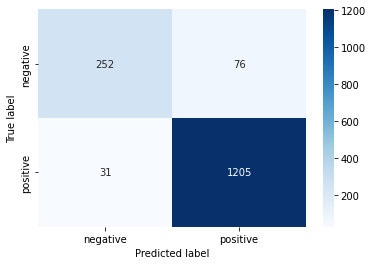

In [68]:
plot_matrix(y_test, y_pred)

#### Word2Vec

In [69]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_word2vec_scaled,y_train)
y_pred = SVM.predict(X_test_word2vec_scaled)

In [70]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       328
    positive       0.79      1.00      0.88      1236

    accuracy                           0.79      1564
   macro avg       0.40      0.50      0.44      1564
weighted avg       0.62      0.79      0.70      1564



/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

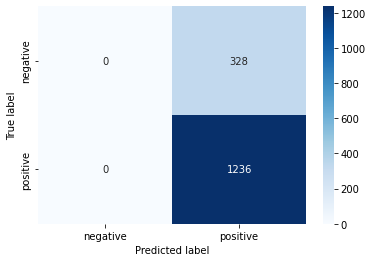

In [71]:
plot_matrix(y_test, y_pred)

#### Fasttext

In [72]:
# SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
# SVM.fit(X_train_fasttext_scaled,y_train)
# y_pred = SVM.predict(X_test_fasttext_scaled)

In [73]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [74]:
# plot_matrix(y_test, y_pred)

#### Bag of Words

In [75]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(countword_train,y_train)
y_pred = SVM.predict(countword_test)

In [76]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.90      0.81      0.85       328
    positive       0.95      0.98      0.96      1236

    accuracy                           0.94      1564
   macro avg       0.93      0.89      0.91      1564
weighted avg       0.94      0.94      0.94      1564



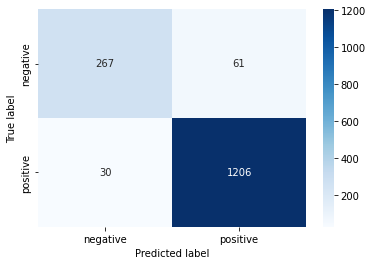

In [77]:
plot_matrix(y_test, y_pred)

### Naive Bayes

#### TF-IDF

In [78]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(tfidf_train,y_train)
y_pred = Naive.predict(tfidf_test)

In [79]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.84      0.52      0.65       328
    positive       0.89      0.97      0.93      1236

    accuracy                           0.88      1564
   macro avg       0.86      0.75      0.79      1564
weighted avg       0.88      0.88      0.87      1564



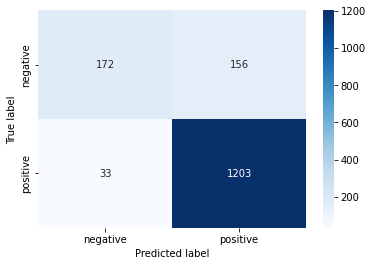

In [80]:
plot_matrix(y_test, y_pred)

#### Word2Vec

In [81]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_word2vec_scaled,y_train)
y_pred = Naive.predict(X_test_word2vec_scaled)

In [82]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       328
    positive       0.79      1.00      0.88      1236

    accuracy                           0.79      1564
   macro avg       0.40      0.50      0.44      1564
weighted avg       0.62      0.79      0.70      1564



/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

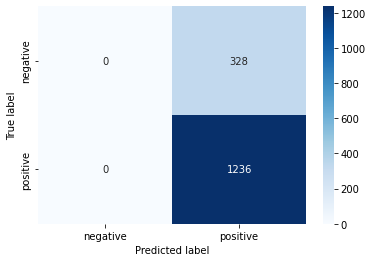

In [83]:
plot_matrix(y_test, y_pred)

#### Fasttext

In [84]:
# Naive = naive_bayes.MultinomialNB()
# Naive.fit(X_train_fasttext_scaled,y_train)
# y_pred = Naive.predict(X_test_fasttext_scaled)

In [85]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [86]:
# plot_matrix(y_test, y_pred)

#### Bag of Words

In [87]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(countword_train,y_train)
y_pred = Naive.predict(countword_test)

In [88]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.71      0.72      0.72       328
    positive       0.92      0.92      0.92      1236

    accuracy                           0.88      1564
   macro avg       0.82      0.82      0.82      1564
weighted avg       0.88      0.88      0.88      1564



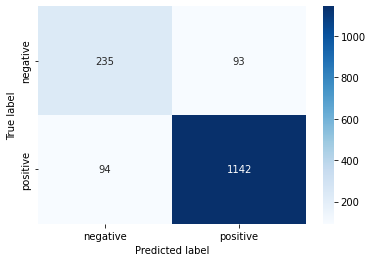

In [89]:
plot_matrix(y_test, y_pred)

### Logistic Regression

#### TF-IDF

In [90]:
logistic = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
logistic.fit(tfidf_train,y_train)
y_pred = logistic.predict(tfidf_test)

/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.81      0.85       328
    positive       0.95      0.97      0.96      1236

    accuracy                           0.94      1564
   macro avg       0.92      0.89      0.91      1564
weighted avg       0.94      0.94      0.94      1564



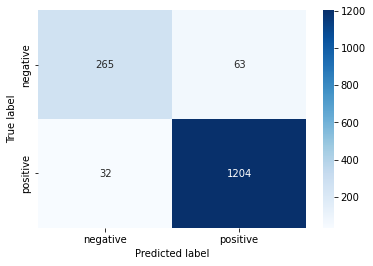

In [92]:
plot_matrix(y_test, y_pred)

#### Word2Vec

In [93]:
logistic = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
logistic .fit(X_train_word2vec_scaled,y_train)
y_pred = logistic .predict(X_test_word2vec_scaled)

/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.50      0.02      0.04       328
    positive       0.79      0.99      0.88      1236

    accuracy                           0.79      1564
   macro avg       0.65      0.51      0.46      1564
weighted avg       0.73      0.79      0.71      1564



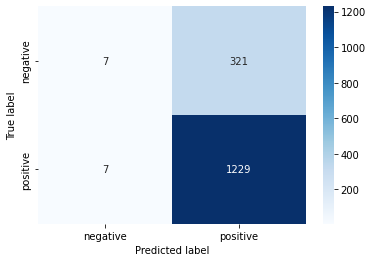

In [95]:
plot_matrix(y_test, y_pred)

#### Fasttext

In [96]:
# logistic = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
# logistic.fit(X_train_fasttext_scaled,y_train)
# y_pred = logistic.predict(X_test_fasttext_scaled)

In [97]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [98]:
# plot_matrix(y_test, y_pred)

#### Bag of Words

In [99]:
logistic = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
logistic.fit(countword_train,y_train)
y_pred = logistic.predict(countword_test)

/media/DATA/Apps-Files/Linux/Miniconda3/envs/data-mining/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.89      0.82      0.86       328
    positive       0.95      0.97      0.96      1236

    accuracy                           0.94      1564
   macro avg       0.92      0.90      0.91      1564
weighted avg       0.94      0.94      0.94      1564



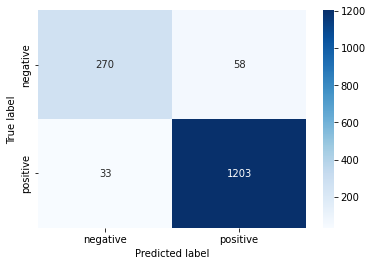

In [101]:
plot_matrix(y_test, y_pred)

### KNN

#### TF-IDF

In [102]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(tfidf_train,y_train)
y_pred = logistic.predict(tfidf_test)

In [103]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.96      0.52      0.67       328
    positive       0.89      0.99      0.94      1236

    accuracy                           0.89      1564
   macro avg       0.92      0.75      0.80      1564
weighted avg       0.90      0.89      0.88      1564



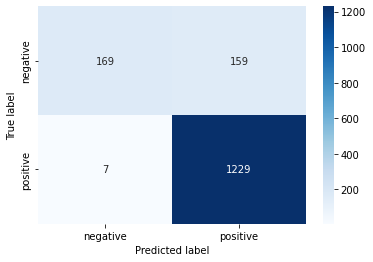

In [104]:
plot_matrix(y_test, y_pred)

#### Word2Vec

In [105]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_word2vec_scaled,y_train)
y_pred = knn.predict(X_test_word2vec_scaled)

In [106]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.63      0.39      0.48       328
    positive       0.85      0.94      0.89      1236

    accuracy                           0.82      1564
   macro avg       0.74      0.66      0.69      1564
weighted avg       0.81      0.82      0.81      1564



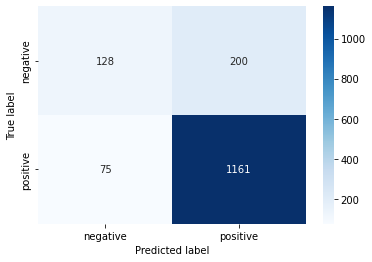

In [107]:
plot_matrix(y_test, y_pred)

#### Fasttext

In [108]:
# knn = KNeighborsClassifier(n_neighbors=7)
# knn.fit(X_train_fasttext_scaled,y_train)
# y_pred = knn.predict(X_test_fasttext_scaled)

In [109]:
# print(classification_report(y_test, y_pred, target_names=target_names))

In [110]:
# plot_matrix(y_test, y_pred)

#### Bag of Words

In [111]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(countword_train,y_train)
y_pred = knn.predict(countword_test)

In [112]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.95      0.38      0.54       328
    positive       0.86      0.99      0.92      1236

    accuracy                           0.87      1564
   macro avg       0.90      0.69      0.73      1564
weighted avg       0.88      0.87      0.84      1564



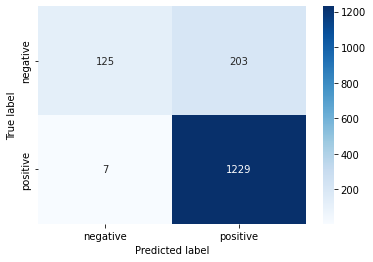

In [113]:
plot_matrix(y_test, y_pred)